In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class MakeClass(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.num_class = num_class

    def forward(self, x):
        x[x == 255] = 21
        return F.one_hot(x.to(torch.int64), self.num_class).permute(0, 3, 1, 2)[0].float()

transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.PILToTensor(), 
        MakeClass(22)
    ]
)

train_ds = VOCSegmentation(
    root = "~/data", image_set = "train", download = True, year = "2007",
    transform = transform, 
    target_transform = target_transform
)

valid_ds = VOCSegmentation(
    root = "~/data", image_set = "trainval", download = True, year = "2007",
    transform = transform, 
    target_transform = target_transform    
)

test_ds = VOCSegmentation(
    root = "~/data", image_set = "val", download = True, year = "2007",
    transform = transform, 
    target_transform = target_transform
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Validation Samples: {}".format(len(valid_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Validation Batch: {}".format(len(valid_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

Using downloaded and verified file: /home/khoidh/data/VOCtrainval_06-Nov-2007.tar
Extracting /home/khoidh/data/VOCtrainval_06-Nov-2007.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_06-Nov-2007.tar
Extracting /home/khoidh/data/VOCtrainval_06-Nov-2007.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_06-Nov-2007.tar
Extracting /home/khoidh/data/VOCtrainval_06-Nov-2007.tar to /home/khoidh/data
#Training Samples: 209
#Validation Samples: 422
#Testing Samples: 213
#Training Batch: 7
#Validation Batch: 14
#Testing Batch: 7


Total #Class: 22
data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([22, 256, 256])
Number classes: 22
Classes: tensor([ 0,  5, 15, 21])


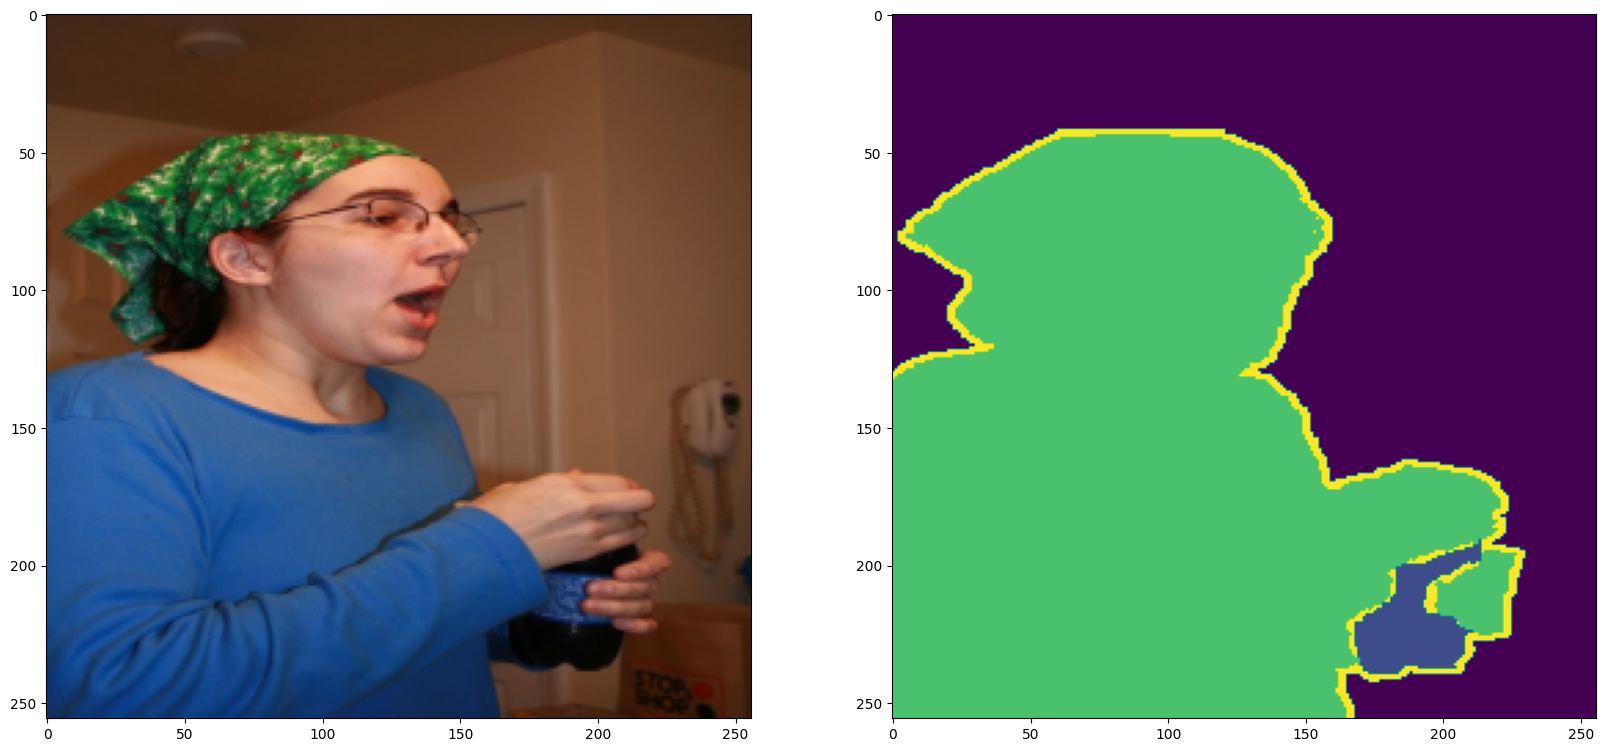

In [3]:
sample_data, sample_mask = train_ds[200]
total_num_class = 22

print(f"Total #Class: {total_num_class}")
print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")
num_class = sample_mask.shape[0]
print(f"Number classes: {num_class}")
print(f"Classes: {torch.unique(torch.argmax(sample_mask, dim = 0))}")

f, axarr = plt.subplots(1, 2, figsize=(20, 15))
axarr[0].imshow(sample_data.permute(1, -1, 0).numpy())
axarr[1].imshow(torch.argmax(sample_mask, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [5]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [6]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [7]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [9]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, total_num_class, True).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [11]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)
        train_rec_loss = loss_fn(train_gen_mask, train_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            train_mask.float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.cpu().item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(valid_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device)
            
            valid_gen_mask = model(valid_img)
            valid_rec_loss = loss_fn(valid_gen_mask, valid_mask)
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                valid_mask.float(),
                multiclass=True
            )
            valid_loss = valid_rec_loss + valid_dice_loss

            va_total_loss += valid_loss.cpu().item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.64it/s]


Epoch: 0 - TrainLoss: 3.945995262690953 - ValidLoss: 7.697413853236607


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.88it/s]


Epoch: 1 - TrainLoss: 3.580808332988194 - ValidLoss: 6.656602655138288


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.79it/s]


Epoch: 2 - TrainLoss: 3.3593251705169678 - ValidLoss: 6.695507253919329


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.89it/s]


Epoch: 3 - TrainLoss: 3.2046224730355397 - ValidLoss: 5.435718774795532


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.84it/s]


Epoch: 4 - TrainLoss: 3.0581303664616177 - ValidLoss: 5.798897300447736


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.88it/s]


Epoch: 5 - TrainLoss: 2.9182743344988142 - ValidLoss: 5.640529121671404


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.87it/s]


Epoch: 6 - TrainLoss: 2.7921698093414307 - ValidLoss: 5.988428286143711


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.80it/s]


Epoch: 7 - TrainLoss: 2.6812306131635393 - ValidLoss: 5.696304593767438


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.93it/s]


Epoch: 8 - TrainLoss: 2.565743480409895 - ValidLoss: 5.210977111543928


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.83it/s]


Epoch: 9 - TrainLoss: 2.475653988974435 - ValidLoss: 5.736930540629795


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.97it/s]


Epoch: 10 - TrainLoss: 2.404440028326852 - ValidLoss: 4.965030465807233


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.04it/s]


Epoch: 11 - TrainLoss: 2.3024817194257463 - ValidLoss: 4.9468139580317905


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.93it/s]


Epoch: 12 - TrainLoss: 2.1991940907069614 - ValidLoss: 4.856023073196411


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.43it/s]


Epoch: 13 - TrainLoss: 2.1380393505096436 - ValidLoss: 4.678651877811977


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.34it/s]


Epoch: 14 - TrainLoss: 2.1023804800851003 - ValidLoss: 4.23188430922372


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.36it/s]


Epoch: 15 - TrainLoss: 2.0060244458062306 - ValidLoss: 3.7459005628313338


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.28it/s]


Epoch: 16 - TrainLoss: 1.9878931726728166 - ValidLoss: 3.951575364385332


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.44it/s]


Epoch: 17 - TrainLoss: 1.933450698852539 - ValidLoss: 3.9080568041120256


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.55it/s]


Epoch: 18 - TrainLoss: 1.882376296179635 - ValidLoss: 4.141572935240609


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.29it/s]


Epoch: 19 - TrainLoss: 1.8291598899023873 - ValidLoss: 3.9702537740979875


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.28it/s]


Epoch: 20 - TrainLoss: 1.801382371357509 - ValidLoss: 3.860876441001892


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]


Epoch: 21 - TrainLoss: 1.7777267864772253 - ValidLoss: 4.0486213479723245


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]


Epoch: 22 - TrainLoss: 1.764130881854466 - ValidLoss: 3.9583771909986223


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.29it/s]


Epoch: 23 - TrainLoss: 1.7001067229679652 - ValidLoss: 3.6560517379215787


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.34it/s]


Epoch: 24 - TrainLoss: 1.7183587040219988 - ValidLoss: 3.5425622122628346


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.51it/s]


Epoch: 25 - TrainLoss: 1.7023944173540388 - ValidLoss: 3.3733037369591847


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.29it/s]


Epoch: 26 - TrainLoss: 1.649130174091884 - ValidLoss: 3.5908693415778026


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]


Epoch: 27 - TrainLoss: 1.6735225405011858 - ValidLoss: 3.379433648926871


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.44it/s]


Epoch: 28 - TrainLoss: 1.6455493654523576 - ValidLoss: 3.271952850478036


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.36it/s]


Epoch: 29 - TrainLoss: 1.633679713521685 - ValidLoss: 3.514619622911726


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.32it/s]


Epoch: 30 - TrainLoss: 1.5894239459718977 - ValidLoss: 3.3819752420697893


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.50it/s]


Epoch: 31 - TrainLoss: 1.590766327721732 - ValidLoss: 3.340087890625


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.26it/s]


Epoch: 32 - TrainLoss: 1.5833268506186349 - ValidLoss: 3.257603236607143


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.30it/s]


Epoch: 33 - TrainLoss: 1.5471218994685583 - ValidLoss: 3.2371229444231306


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.28it/s]


Epoch: 34 - TrainLoss: 1.5514304808207922 - ValidLoss: 3.416274513517107


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.40it/s]


Epoch: 35 - TrainLoss: 1.5500523022242956 - ValidLoss: 3.2535239287785123


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.32it/s]


Epoch: 36 - TrainLoss: 1.5526446274348669 - ValidLoss: 3.2846599817276


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.21it/s]


Epoch: 37 - TrainLoss: 1.5183540412357874 - ValidLoss: 3.4265539816447665


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.41it/s]


Epoch: 38 - TrainLoss: 1.5140111616679601 - ValidLoss: 3.2498214755739485


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.45it/s]


Epoch: 39 - TrainLoss: 1.5562755039760046 - ValidLoss: 3.3129428454807828


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.52it/s]


Epoch: 40 - TrainLoss: 1.5060384103230067 - ValidLoss: 3.1283410361834934


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.29it/s]


Epoch: 41 - TrainLoss: 1.471316627093724 - ValidLoss: 3.144741007259914


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.57it/s]


Epoch: 42 - TrainLoss: 1.4501714195523943 - ValidLoss: 3.2062278985977173


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.39it/s]


Epoch: 43 - TrainLoss: 1.4341520922524589 - ValidLoss: 3.149305513926915


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]


Epoch: 44 - TrainLoss: 1.4376364946365356 - ValidLoss: 3.483656167984009


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.37it/s]


Epoch: 45 - TrainLoss: 1.4113107579095023 - ValidLoss: 3.2575291054589406


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.17it/s]


Epoch: 46 - TrainLoss: 1.4146537780761719 - ValidLoss: 3.164300901549203


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.27it/s]


Epoch: 47 - TrainLoss: 1.386401925768171 - ValidLoss: 3.21555381161826


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.34it/s]


Epoch: 48 - TrainLoss: 1.3874718802315849 - ValidLoss: 3.1571609463010515


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.43it/s]


Epoch: 49 - TrainLoss: 1.3642731394086565 - ValidLoss: 3.0842746836798534


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.19it/s]


Epoch: 50 - TrainLoss: 1.3643141644341605 - ValidLoss: 3.1548625230789185


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]


Epoch: 51 - TrainLoss: 1.3915067570550101 - ValidLoss: 3.1647750650133406


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]


Epoch: 52 - TrainLoss: 1.3708501373018538 - ValidLoss: 3.0421344552721297


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.29it/s]


Epoch: 53 - TrainLoss: 1.352174963269915 - ValidLoss: 3.1447207587105885


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.34it/s]


Epoch: 54 - TrainLoss: 1.339578492300851 - ValidLoss: 3.0678469964436124


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.28it/s]


Epoch: 55 - TrainLoss: 1.3105405228478568 - ValidLoss: 3.0916161026273454


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.40it/s]


Epoch: 56 - TrainLoss: 1.2924662487847465 - ValidLoss: 3.0273031847817555


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.47it/s]


Epoch: 57 - TrainLoss: 1.294005376952035 - ValidLoss: 2.8971024325915744


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.50it/s]


Epoch: 58 - TrainLoss: 1.2515719788415092 - ValidLoss: 2.9788761479513988


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.41it/s]


Epoch: 59 - TrainLoss: 1.2723405020577567 - ValidLoss: 3.1085545676095143


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.15it/s]


Epoch: 60 - TrainLoss: 1.264808280127389 - ValidLoss: 2.963473916053772


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.08it/s]


Epoch: 61 - TrainLoss: 1.2110940388270788 - ValidLoss: 2.9910110575812205


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.24it/s]


Epoch: 62 - TrainLoss: 1.250136375427246 - ValidLoss: 2.881087166922433


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.33it/s]


Epoch: 63 - TrainLoss: 1.243545344897679 - ValidLoss: 2.8562265975134715


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.11it/s]


Epoch: 64 - TrainLoss: 1.1911145108086723 - ValidLoss: 2.944201810019357


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.22it/s]


Epoch: 65 - TrainLoss: 1.1709339448383875 - ValidLoss: 2.885070187704904


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.34it/s]


Epoch: 66 - TrainLoss: 1.1789235728127616 - ValidLoss: 2.9454185962677


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.23it/s]


Epoch: 67 - TrainLoss: 1.1646674871444702 - ValidLoss: 2.8163421154022217


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.29it/s]


Epoch: 68 - TrainLoss: 1.1317967857633318 - ValidLoss: 2.875600218772888


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.07it/s]


Epoch: 69 - TrainLoss: 1.103818186691829 - ValidLoss: 2.8107291630336215


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.13it/s]


Epoch: 70 - TrainLoss: 1.1232456054006303 - ValidLoss: 2.8090780632836476


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.95it/s]


Epoch: 71 - TrainLoss: 1.1159540329660689 - ValidLoss: 2.8911468301500594


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.04it/s]


Epoch: 72 - TrainLoss: 1.1024153573172433 - ValidLoss: 2.8930729797908237


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.96it/s]


Epoch: 73 - TrainLoss: 1.0995396971702576 - ValidLoss: 2.836342249597822


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.12it/s]


Epoch: 74 - TrainLoss: 1.0804172924586706 - ValidLoss: 2.862071854727609


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.04it/s]


Epoch: 75 - TrainLoss: 1.1220944268362862 - ValidLoss: 2.7840979439871654


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.05it/s]


Epoch: 76 - TrainLoss: 1.0652555227279663 - ValidLoss: 3.008878912244524


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.94it/s]


Epoch: 77 - TrainLoss: 1.0448068806103297 - ValidLoss: 2.8066709552492415


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.93it/s]


Epoch: 78 - TrainLoss: 1.059518277645111 - ValidLoss: 2.767566510609218


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.75it/s]


Epoch: 79 - TrainLoss: 1.0251725912094116 - ValidLoss: 2.8710244383130754


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.84it/s]


Epoch: 80 - TrainLoss: 1.0226206864629472 - ValidLoss: 2.7324757490839278


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.82it/s]


Epoch: 81 - TrainLoss: 1.0247822574206762 - ValidLoss: 2.7675785337175642


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.66it/s]


Epoch: 82 - TrainLoss: 1.0117927704538618 - ValidLoss: 2.7567345244543895


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.72it/s]


Epoch: 83 - TrainLoss: 0.9891148975917271 - ValidLoss: 2.6887750199862888


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.55it/s]


Epoch: 84 - TrainLoss: 0.9820848447935921 - ValidLoss: 2.7665034191949025


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.68it/s]


Epoch: 85 - TrainLoss: 1.0022355232919966 - ValidLoss: 2.758005840437753


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.64it/s]


Epoch: 86 - TrainLoss: 1.0204461898122514 - ValidLoss: 2.74567597252982


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.05it/s]


Epoch: 87 - TrainLoss: 0.9826784900256565 - ValidLoss: 2.7377907378332957


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.35it/s]


Epoch: 88 - TrainLoss: 0.9838825038501194 - ValidLoss: 2.699477093560355


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.18it/s]


Epoch: 89 - TrainLoss: 0.9794242296900068 - ValidLoss: 2.7655607291630337


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.25it/s]


Epoch: 90 - TrainLoss: 0.9763916560581752 - ValidLoss: 2.70180298600878


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.86it/s]


Epoch: 91 - TrainLoss: 1.0222506948879786 - ValidLoss: 2.7070243869509016


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.20it/s]


Epoch: 92 - TrainLoss: 1.019390080656324 - ValidLoss: 2.7814146961484636


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.01it/s]


Epoch: 93 - TrainLoss: 0.9694606406348092 - ValidLoss: 2.690953407968794


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.08it/s]


Epoch: 94 - TrainLoss: 0.9600970830236163 - ValidLoss: 2.669294927801405


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.04it/s]


Epoch: 95 - TrainLoss: 0.9754929712840489 - ValidLoss: 2.719339983803885


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.09it/s]


Epoch: 96 - TrainLoss: 0.9806688683373588 - ValidLoss: 2.770771333149501


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.99it/s]


Epoch: 97 - TrainLoss: 1.01101872750691 - ValidLoss: 2.693315863609314


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.02it/s]


Epoch: 98 - TrainLoss: 0.9826820152146476 - ValidLoss: 2.695349488939558


100%|████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.89it/s]

Epoch: 99 - TrainLoss: 0.9727439028876168 - ValidLoss: 2.7024803161621094


<All keys matched successfully>

In [12]:
model.eval()
with torch.no_grad():
    ts_total_loss = 0
    for test_img, test_mask in tqdm(test_dl):
        test_img = test_img.to(device)
        test_mask = test_mask.to(device)
        
        test_gen_mask = model(test_img)
        test_rec_loss = loss_fn(test_gen_mask, test_mask)
        test_dice_loss = dice_loss(
            F.softmax(test_gen_mask, dim=1).float(),
            test_mask.float(),
            multiclass=True
        )
        test_loss = test_rec_loss + test_dice_loss

        ts_total_loss += test_loss.cpu().item()
mean_test_loss = ts_total_loss/len(test_dl)
print(f"TestLoss: {mean_test_loss}")

100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.09it/s]

TestLoss: 1.7647790227617537


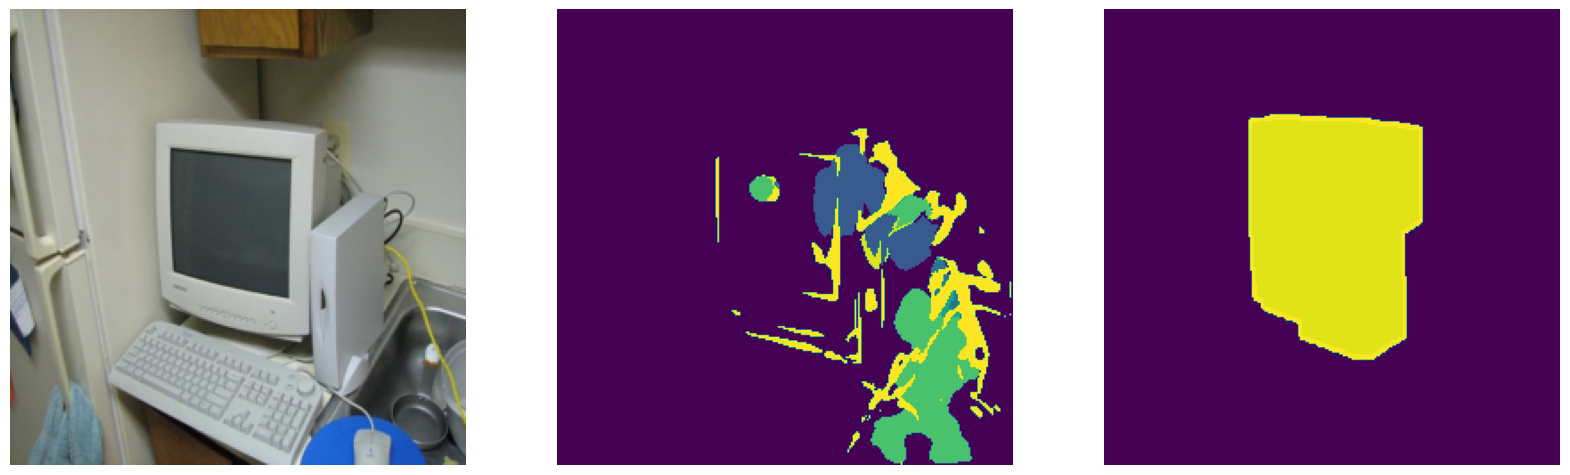

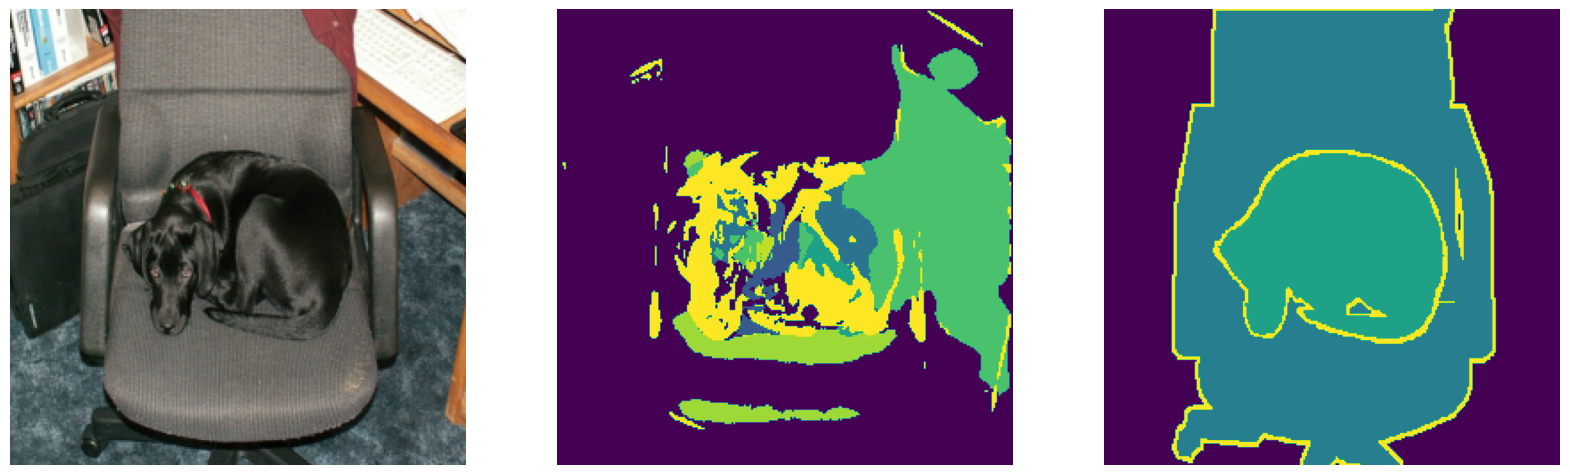

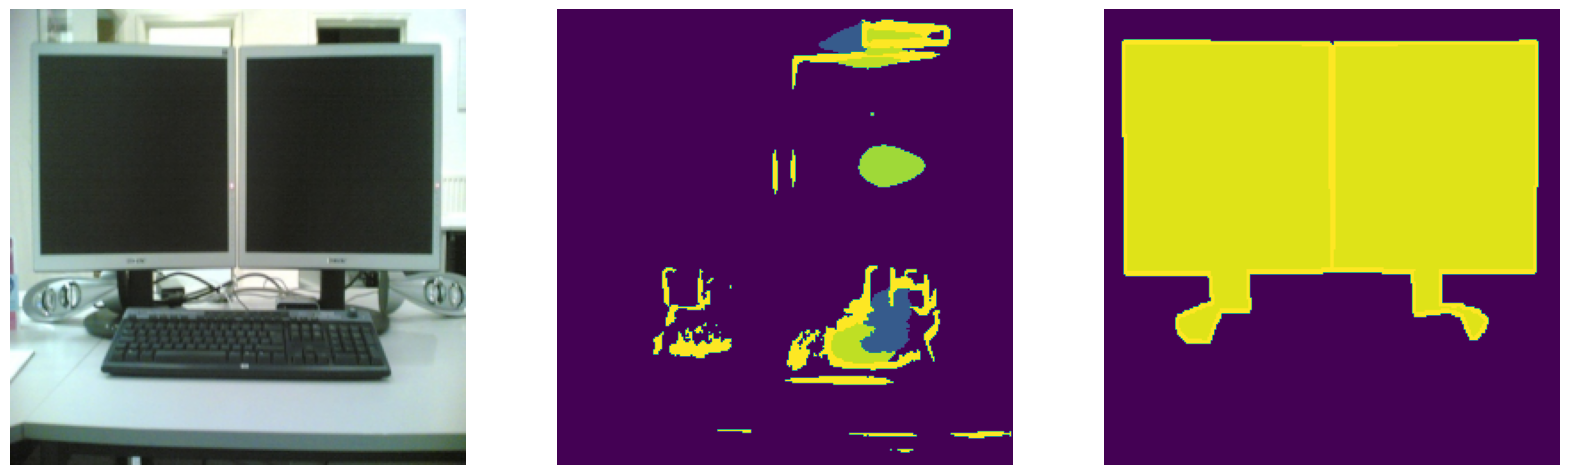

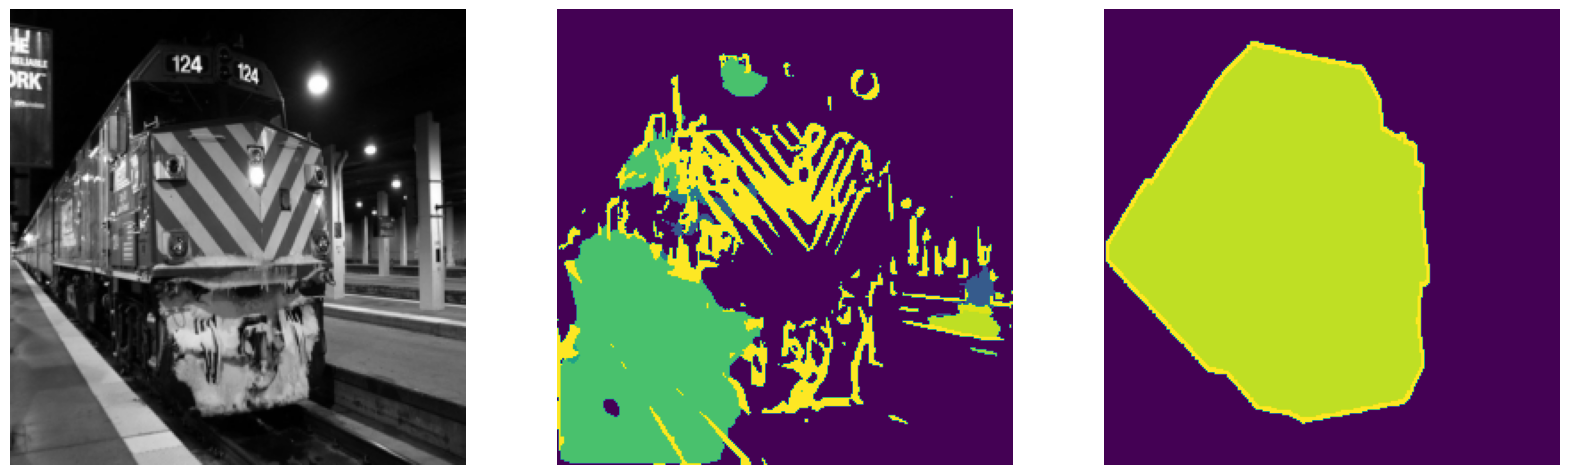

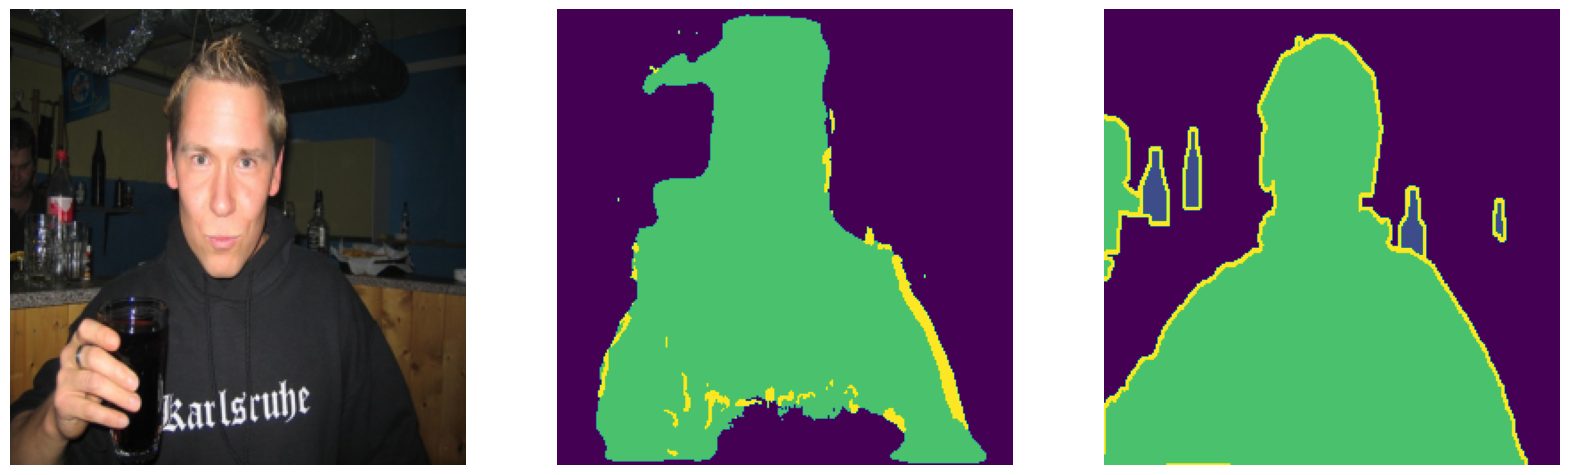

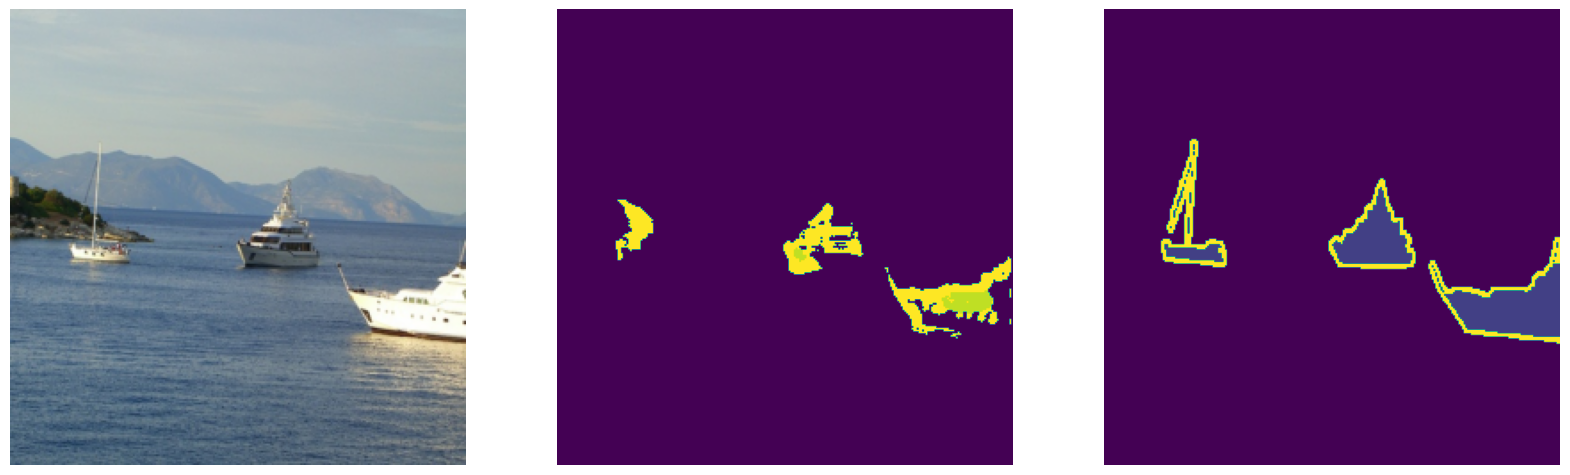

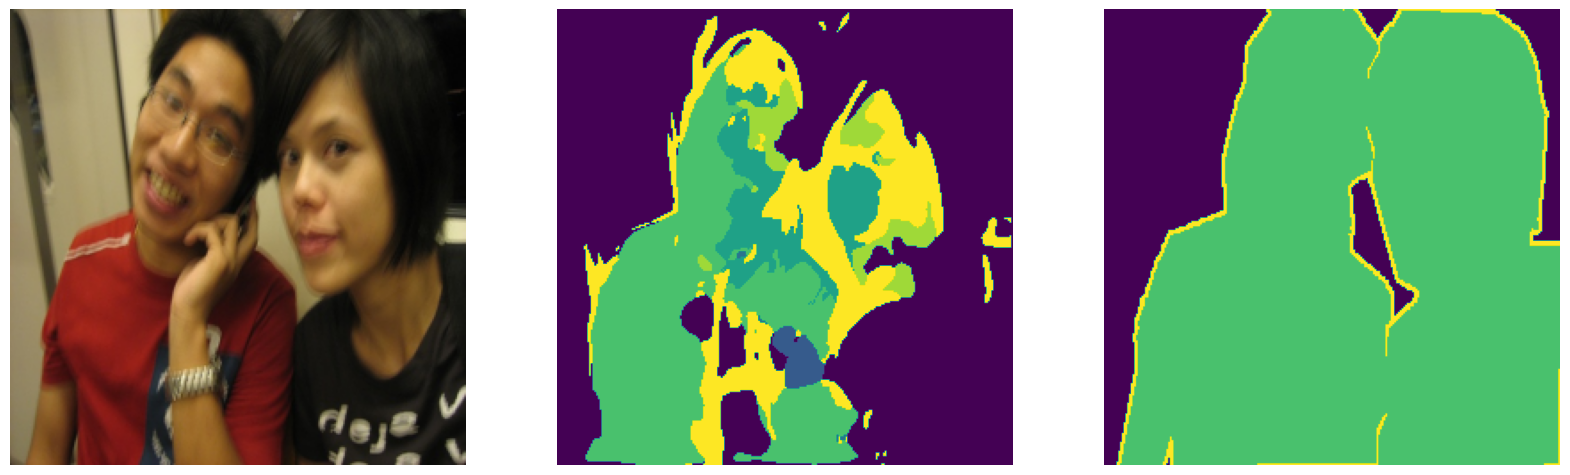

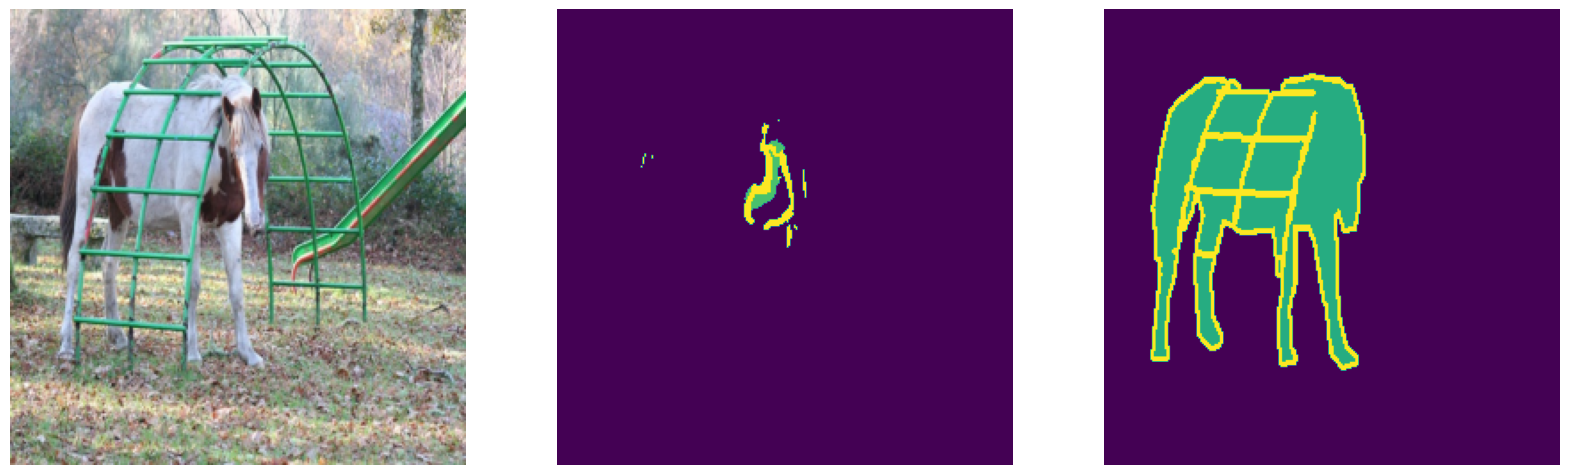

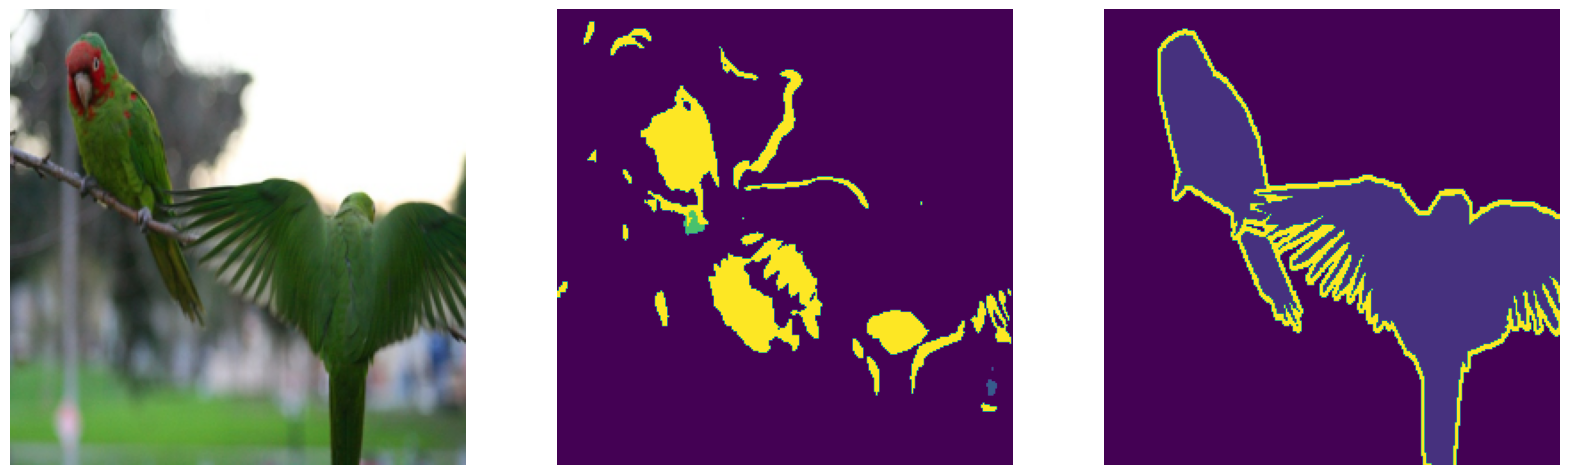

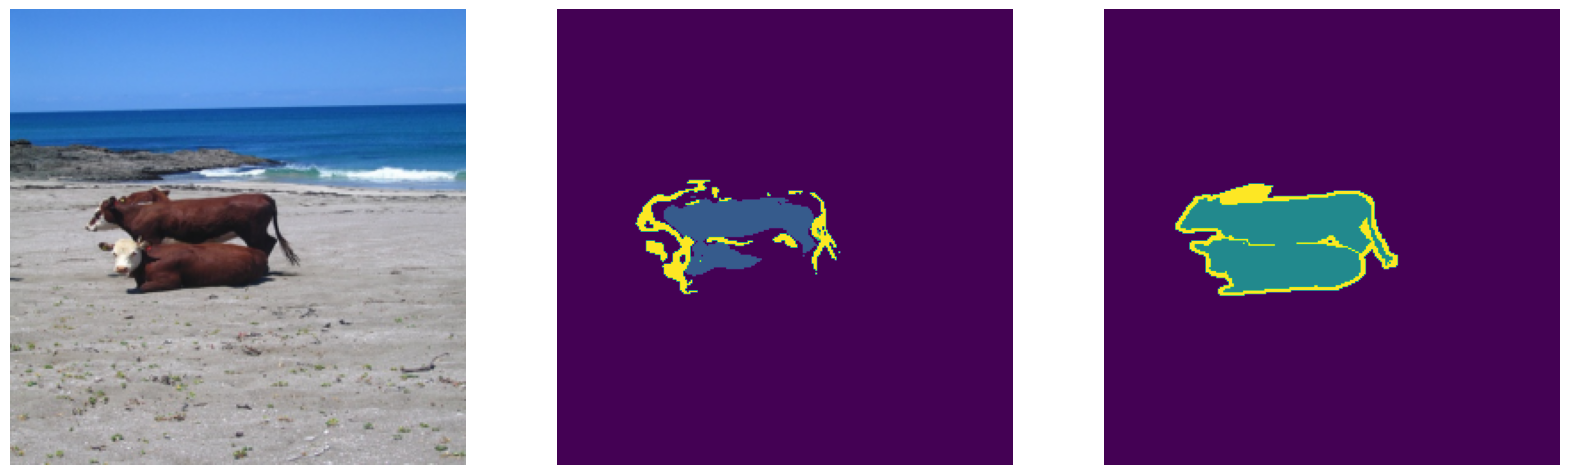

In [13]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(torch.argmax(valid_mask, dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')